# Pre-trained CNN for behaviours detection

## Imports and constants

In [1]:
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Embedding,
    GRU,
    Bidirectional,
    RepeatVector,
    TimeDistributed,
)
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from os import listdir
from os.path import isfile, join

import os

print(tf.__version__)

2023-11-21 02:43:42.427031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 02:43:42.451605: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 02:43:42.451643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 02:43:42.451668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 02:43:42.457051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 02:43:42.457541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

2.14.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay

import scipy.stats as stats
import sqlite3
import gc

In [3]:
training_device: str = "cpu"

if str.lower(training_device) == "cpu":
    tf.config.set_visible_devices(
        devices=[],
        device_type="GPU",
    )
else:
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data pre-processing

### Load the Dataset

In [4]:
def load_data_sqlite() -> pd.DataFrame:
    connection: sqlite3.Connection = sqlite3.connect(
        database="drive/MyDrive/Ellinbank/video_observation/data/ellinbank_cow-observation_labeled-data.db"
    )
    cursor: sqlite3.Cursor = connection.cursor()

    DATABASE_NAME: str = "LebeledDataTable"

    query: str = """
    select distinct serial_number
    from {}
    """.format(
        DATABASE_NAME
    )

    response: sqlite3.Cursor = cursor.execute(query)
    file_names: list = list(response)
    file_names = [file[0] for file in file_names]

    dataframes: list = []
    for file in file_names:
        query: str = """
            select *
            from {}
            where serial_number = '{}'
        """.format(
            DATABASE_NAME,
            file,
        )
        df: pd.DataFrame = pd.read_sql_query(
            sql=query,
            con=connection,
        )
        dataframes.append(df)
        # break

    dataframe: pd.DataFrame = pd.concat(dataframes)
    return dataframe

In [5]:
notebook_mode: str = "developing"
if notebook_mode == "developing":
    full_data: pd.DataFrame = pd.read_csv("../../../data/ellinbank_cow-data_small.csv")
else:
    full_data: pd.DataFrame = load_data_sqlite()

In [6]:
all_cows: list = full_data["nickname"].unique()
all_cows

array(['COW3', 'COW8', 'COW11', 'COW17', 'COW19'], dtype=object)

### Removing `\n` values and lowercase all entries

In [7]:
full_data.replace(
    to_replace="\n",
    value="",
    regex=True,
    inplace=True,
)
full_data["Behaviour"] = full_data["Behaviour"].str.lower()

### Removing empty behaviours

In [8]:
full_data = full_data.drop(
    full_data[full_data["Behaviour"] == ""].index,
    inplace=False,
)
behaviour_col_values: np.ndarray = full_data["Behaviour"].unique()
print(behaviour_col_values)
print((full_data["Behaviour"].value_counts()))

['g' 'w' 'o' 'i' 'r' 'd' 'u']
Behaviour
g    9000
w    9000
o    9000
i    9000
r    9000
u    4720
d    4030
Name: count, dtype: int64


### Check for duplicated rows and null values

In [9]:
duplicated_rows: pd.Series = full_data.duplicated()
duplicated_rows = duplicated_rows[duplicated_rows == True]
print("{} rows duplicated".format(duplicated_rows.shape))

full_data.drop_duplicates(inplace=True)

print(full_data.isnull().sum())
print(full_data.isna().sum())

(0,) rows duplicated
serial_number          0
nickname               0
animalID               0
sample_rate            0
timestamps             0
Behaviour              0
acc_axis1              0
acc_axis2              0
acc_axis3              0
acc_mag                0
lpf_axis1              0
lpf_axis2              0
lpf_axis3              0
lpf_mag                0
hpf_axis1              0
hpf_axis2              0
hpf_axis3              0
hpf_mag                0
spd_axis1              0
spd_axis2              0
spd_axis3              0
spd_mag                0
spd_axis1_denoised     0
spd_axis2_denoised     0
spd_axis3_denoised     0
spd_mag_denoised       0
dis_axis1              0
dis_axis2              0
dis_axis3              0
dis_mag                0
dis_axis1_denoised     0
dis_axis2_denoised     0
dis_axis3_denoised     0
dis_mag_denoised       0
tilt_axis1             0
tilt_axis2             0
tilt_axis3             0
tilt_axis1_denoised    0
tilt_axis2_denoised    0
tilt

In [10]:
full_data.head(1)

,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis1_denoised,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised
0,COW3_4_thur_final,COW3,3.0,30.0,2023-04-27 09:11:42.000000,g,-0.703,-0.539,0.227,0.914472,...,-10.99752,15.326401,-2.054346,18.975362,-60.483006,-24.392151,74.414919,-59.035276,-27.707135,77.272273


### Sort data based on date
This ensure that actvities are read in a consecutive order and reseting the index of readings (rows).

In [11]:
full_data.sort_values(
    by=["timestamps"],
    ascending=True,
    inplace=True,
)

full_data = full_data.reset_index(drop=True)

### Convert numerical values (input data) to float type

In [12]:
full_data.iloc[:, 6:] = full_data.iloc[:, 6:].astype("float")
# train_df: pd.DataFrame = full_data.copy()

gc.collect()

108

['d' 'g' 'i' 'o' 'r' 'u' 'w']
[4030 9000 9000 9000 9000 4720 9000]


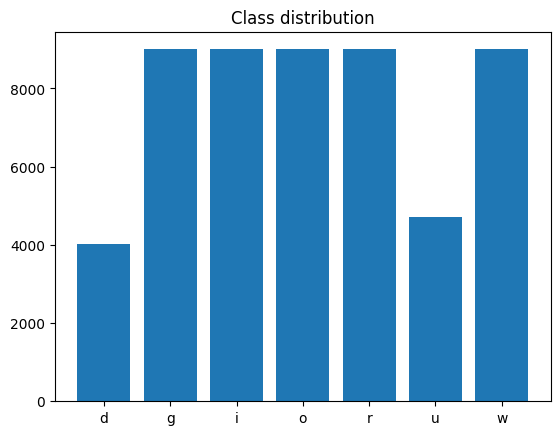

In [13]:
# Class distribution, will use later but should use seaborn to show labels on columns.
existing_labels: np.ndarray = full_data["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

### Handle minor classes
Classes with smaller number of records will be either merged with another class or be removed completely.

In [14]:
from utils import handle_minor_classes


# full_data = handle_minor_classes(
#     data=full_data,
#     minor_classes=["u"],
#     type="remove",
# )
full_data = handle_minor_classes(
    data=full_data,
    minor_classes=["d", "w", "u"],
    type="merge",
)
gc.collect()

3377

['g' 'i' 'o' 'r']
[ 9000  9000 26750  9000]


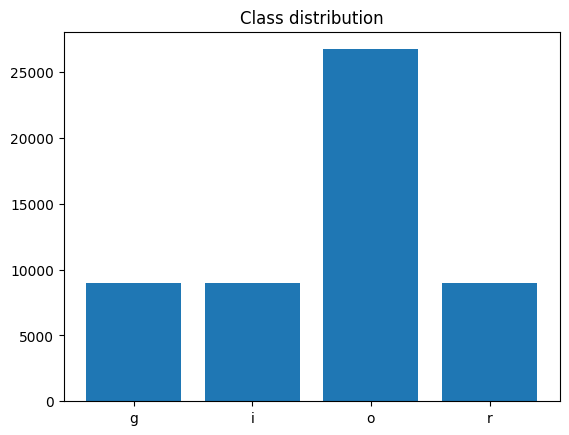

In [15]:
# Class distribution after dropping/merging minor classes.
existing_labels: np.ndarray = full_data["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

### Encode classes using numerical values.

In [16]:
label = LabelEncoder()
full_data["label"] = label.fit_transform(full_data["Behaviour"])
# unique_labels: np.ndarray = (
#     full_data.groupby(["Behaviour", "label"])
#     .size()
#     .reset_index()["Behaviour"]
#     .to_numpy()
# )


unique_labels: np.ndarray = full_data["label"].unique()
unique_labels.sort()

print(unique_labels)

[0 1 2 3]


### Split cows data into folds for k-fold cross validation.
This process will also remove unnecessary columns and keep only data that will be used for inference.

In [17]:
folds: dict[str, pd.DataFrame] = {}
columns: list = full_data.columns[6:]

for cow in all_cows:
    # For each unique cow, assign its data into a separate dataframe and
    # remove unnecessary columns.
    folds[cow] = full_data.loc[full_data["nickname"] == cow]
    folds[cow] = folds[cow][columns]

# TODO: Remember to delete the full_data dataframe to avoid overflow error.
# del full_data
gc.collect()

3043

### Standardize data.

In [18]:
from utils import standardize_dataframe

for cow in folds.keys():
    standardized_dataframes: pd.DataFrame = standardize_dataframe(
        data=folds[cow],
        std_cols=columns[:-1],
    )
    folds[cow] = standardized_dataframes

gc.collect()

0

In [19]:
folds["COW11"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   acc_axis1            7000 non-null   float64
 1   acc_axis2            7000 non-null   float64
 2   acc_axis3            7000 non-null   float64
 3   acc_mag              7000 non-null   float64
 4   lpf_axis1            7000 non-null   float64
 5   lpf_axis2            7000 non-null   float64
 6   lpf_axis3            7000 non-null   float64
 7   lpf_mag              7000 non-null   float64
 8   hpf_axis1            7000 non-null   float64
 9   hpf_axis2            7000 non-null   float64
 10  hpf_axis3            7000 non-null   float64
 11  hpf_mag              7000 non-null   float64
 12  spd_axis1            7000 non-null   float64
 13  spd_axis2            7000 non-null   float64
 14  spd_axis3            7000 non-null   float64
 15  spd_mag              7000 non-null   f

['COW3' 'COW8' 'COW11' 'COW17' 'COW19']


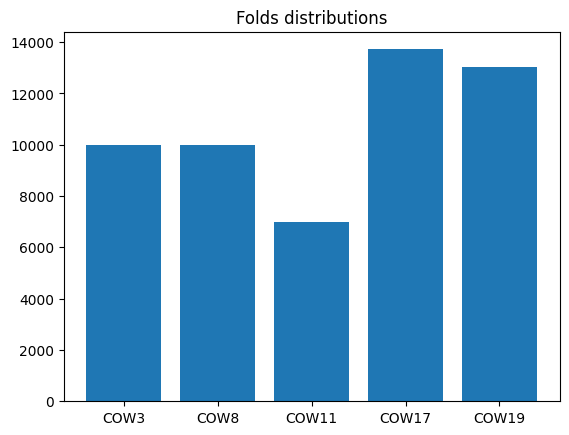

In [20]:
print(all_cows)
no_of_readings_per_cow: list = [len(folds[c]) for c in all_cows]

plt.title("Folds distributions")
plt.bar(all_cows, no_of_readings_per_cow)
plt.show()

## Train-test setup.

### Hyper-parameters

In [21]:
window_size: int = 600  # 300: 10 seconds
window_per_epoch: int = 200
epoch: int = 1
batch_size: int = 64
# random.seed(715) # 715 looks good.
random.seed(785)  # 785 makes "other" looks bad, otherwise is good.

### Models and inference.

In [22]:
# Expected shape: (windows per epoch, window size, 34)
# random.seed(715) # 715 looks good.
random.seed(785)  # 785 makes "other" looks bad, otherwise is good.

from utils import get_frame, get_epoch_frame

In [23]:
from custom_model import CowModel
from inference import Inference

model: tf.keras.Model = CowModel(output_dim=len(existing_types))

In [24]:
input_demo: tf.Tensor = tf.random.normal((1, 300, 34))
output_demo: tf.Tensor = model(input_demo)
output_demo

<tf.Tensor: shape=(1, 300, 4), dtype=float32, numpy=
array([[[ 4.5549917e-01, -9.6856340e-05,  2.3729758e-01,  4.1453347e-01],
        [-1.2423453e+00,  1.0222769e+00, -3.5339418e-01, -6.1993766e-01],
        [ 3.6285043e-01,  4.5599455e-01,  7.6692033e-01,  1.8698272e-01],
        ...,
        [ 2.3866436e-01, -6.9332355e-01,  1.1844549e+00, -3.1690413e-01],
        [ 9.7700071e-01,  3.7168908e-01,  9.9613905e-01,  8.4200191e-01],
        [-1.3692130e-01, -1.9735752e-01,  2.7184099e-01,  2.7065499e-02]]],
      dtype=float32)>

In [25]:
engine: Inference = Inference(
    model=model,
    loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss_metric=tf.keras.metrics.Mean(),
    optimizer=tf.keras.optimizers.Adam(),
    accuracy=tf.keras.metrics.SparseCategoricalAccuracy(),
    batch_size=32,
)

## Train and validate the model.

### Metrics to be collected. 
This should be persisted across folds.

In [26]:
accumulated_metrics: dict[str, list] = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

### Train-test loop with k-fold cross validation.
Each fold will be selected as the validation set and an entire train-test loop will be run using that setup. This will be repeated until all the folds are used.

In [27]:
# Use cow 11 for the final evaluation (testing set).
train_val_cows: list = list(filter(lambda x: (x != "COW11"), all_cows))
test_cows: list = list(filter(lambda x: (x == "COW11"), all_cows))

print(train_val_cows)
print(test_cows)

del all_cows
gc.collect()

['COW3', 'COW8', 'COW17', 'COW19']
['COW11']


207

In [28]:
from tqdm.notebook import tqdm

# for cow in train_val_cows:
for c in tqdm(range(len(train_val_cows))):
    train_cows: list = list(filter(lambda x: (x != train_val_cows[c]), train_val_cows))
    val_cows: list = list(filter(lambda x: (x == train_val_cows[c]), train_val_cows))

    train_data: pd.DataFrame = pd.concat(
        objs=[folds[i] for i in train_cows],
        ignore_index=True,
        sort=True,
    )
    val_data: pd.DataFrame = pd.concat(
        objs=[folds[i] for i in val_cows],
        ignore_index=True,
        sort=True,
    )

    for i in tqdm(range(epoch), leave=False):
        # Generate frames for training and testing dataset.
        x_train, y_train = get_frame(
            df=train_data,
            window_size=window_size,
            window_per_epoch=window_per_epoch,
        )
        x_val, y_val = get_frame(
            df=val_data,
            window_size=window_size,
            window_per_epoch=window_per_epoch,
        )
        gc.collect()

        # Create datasets and use them to train the model. Finally, collect metrics.
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(
            batch_size
        )
        validate_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(
            batch_size
        )
        metrics: dict[str, list] = engine.train_val(
            train_data=train_ds,
            val_data=validate_ds,
            epoch=1,
        )
        accumulated_metrics["train_loss"].extend(metrics["train_loss"])
        accumulated_metrics["train_accuracy"].extend(metrics["train_accuracy"])
        accumulated_metrics["val_loss"].extend(metrics["val_loss"])
        accumulated_metrics["val_accuracy"].extend(metrics["val_accuracy"])

    gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0 - train loss: 1.296447515487671 - train acc: 0.5328583121299744 - test loss: 1.0963021516799927 - test acc: 0.6472916603088379


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0 - train loss: 0.6962114572525024 - train acc: 0.774358332157135 - test loss: 0.6081410646438599 - test acc: 0.7980166673660278


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0 - train loss: 0.431105375289917 - train acc: 0.8594916462898254 - test loss: 1.1575648784637451 - test acc: 0.5444583296775818


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0 - train loss: 0.32088422775268555 - train acc: 0.9172750115394592 - test loss: 0.6660511493682861 - test acc: 0.7672333121299744


## Test and metric evaluations.

### Test results.

In [29]:
test_data: pd.DataFrame = pd.concat(
    objs=[folds[i] for i in test_cows],
    ignore_index=True,
    sort=True,
)
x_test, y_test = get_frame(
    df=test_data,
    window_size=window_size,
    window_per_epoch=window_per_epoch,
)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

test_result: dict = engine.test(test_data=test_ds)
test_result

test loss: 0.6001971960067749 - test acc: 0.7725916504859924


{'test_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=0.6001972>],
 'test_accuracy': [<tf.Tensor: shape=(), dtype=float32, numpy=0.77259165>]}

In [30]:
print("training acc: {}".format(accumulated_metrics["train_accuracy"][-1]))
print("training loss: {}".format(accumulated_metrics["train_loss"][-1]))
print("testing acc: {}".format(test_result["test_accuracy"][-1]))
print("testing loss: {}".format(test_result["test_loss"][-1]))

training acc: 0.9172750115394592
training loss: 0.32088422775268555
testing acc: 0.7725916504859924
testing loss: 0.6001971960067749


### Learning curves.

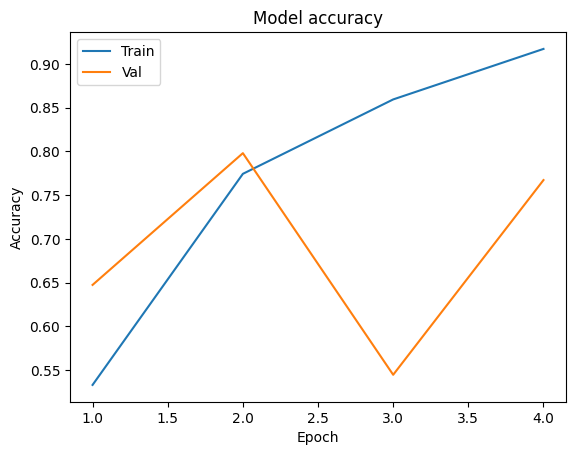

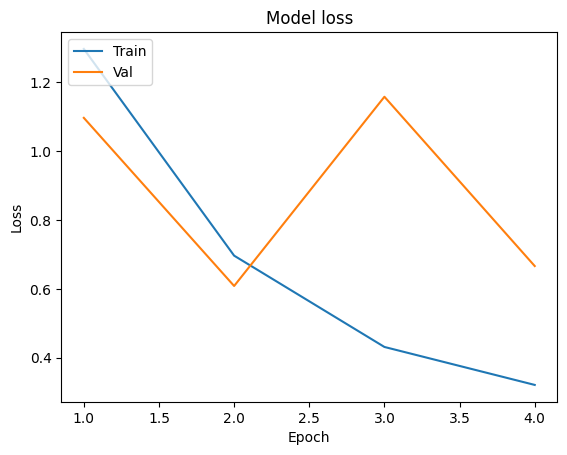

In [31]:
def plot_learningCurve(
    metrics: dict[str, list],
    epochs: int,
):
    # Plot training & validation accuracy values
    epoch_range = range(1, epochs + 1)
    plt.plot(epoch_range, metrics["train_accuracy"])
    plt.plot(epoch_range, metrics["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, metrics["train_loss"])
    plt.plot(epoch_range, metrics["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper left")
    plt.show()


plot_learningCurve(
    metrics=accumulated_metrics,
    epochs=epoch * len(train_val_cows),
)

### Confusion matrix.

In [32]:
data: list = []
labels: list = []

for datum_batch, label_batch in test_ds:
    data.append(datum_batch)
    labels.append(label_batch)

predict_data: np.ndarray = np.concatenate(data)
predict_labels: np.ndarray = np.concatenate(labels)

In [33]:
y_pred: np.ndarray = model.predict(predict_data)

7/7 [==============================] - 0s 6ms/step


In [34]:
y_test_cm: tf.Tensor = tf.reshape(
    tensor=predict_labels,
    shape=(-1),
)

y_pred_cm: tf.Tensor = (
    tf.math.argmax(
        y_pred,
        axis=2,
        output_type=tf.int64,
    ),
)[0]
y_pred_cm = tf.reshape(
    tensor=y_pred_cm,
    shape=(-1),
)

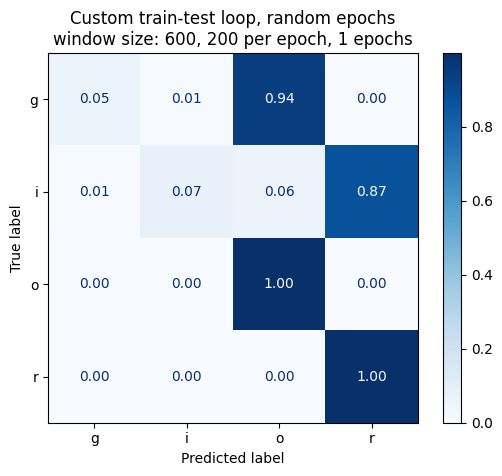

In [35]:
from utils import plot_confusion_matrix

title: str = "Custom train-test loop, random epochs\nwindow size: {}, {} per epoch, {} epochs".format(
    window_size,
    window_per_epoch,
    epoch,
)

plot_confusion_matrix(
    actual=y_test_cm,
    pred=y_pred_cm,
    unique_numerical_labels=unique_labels,
    display_labels=existing_types,
    normalize="true",
    title=title,
)

In [36]:
y_test_cm = tf.cast(
    x=y_test_cm,
    dtype=tf.int64,
)
correct: int = 0
for pred, true in zip(y_pred_cm, y_test_cm):
    if pred == true:
        correct += 1

print(correct / len(y_pred_cm))

0.7725916666666667
